In [ ]:
!pip install uv
!uv pip install  -r requirements.txt 

In [ ]:
import snowflake
from snowflake.snowpark.context import get_active_session
session = get_active_session()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation and analysis
import numpy as np
import pandas as pd
from IPython.display import display

# Multi-dimensional arrays and datasets (e.g., NetCDF, Zarr)
import xarray as xr

# Geospatial raster data handling with CRS support
import rioxarray as rxr

# Raster operations and spatial windowing
import rasterio
from rasterio.windows import Window

# Feature preprocessing and data splitting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Planetary Computer tools for STAC API access and authentication
import pystac_client
import planetary_computer as pc
from odc.stac import stac_load
from pystac.extensions.eo import EOExtension as eo

from datetime import date
from tqdm import tqdm
import os 
from xgboost import XGBRegressor

In [ ]:
!pip install geopandas

In [ ]:
import pandas as pd
import numpy as np

## Load Rivers and Dams data

In [ ]:
import geopandas as gpd
rivers = gpd.read_file("Rivers_Data/Rivers.shp")
rivers.head()

In [ ]:
rivers.crs

## Load the data we want to join

In [ ]:
water_training_df = pd.read_csv("water_quality_training_dataset.csv")
water_training_df.head()

In [ ]:
water_validation_df = pd.read_csv("submission_template.csv")
water_validation_df

In [ ]:
water_training_df.columns

In [ ]:
# define longtitude and latitude column names
lon_col = "Longitude"
lat_col = "Latitude"

water_training_gdf = gpd.GeoDataFrame(
    water_training_df,
    geometry=gpd.points_from_xy(water_training_df[lon_col], water_training_df[lat_col]),
    crs="EPSG:4326"  # Longtitude and latitude
)

print(water_training_gdf.crs)
water_training_gdf.head()

In [ ]:
# define longtitude and latitude column names
lon_col = "Longitude"
lat_col = "Latitude"

water_validation_gdf = gpd.GeoDataFrame(
    water_validation_df,
    geometry=gpd.points_from_xy(water_validation_df[lon_col], water_validation_df[lat_col]),
    crs="EPSG:4326"  # Longtitude and latitude
)

print(water_validation_gdf.crs)
water_validation_gdf.head()


In [ ]:
# Check for the training set
print(water_training_gdf[[lon_col, lat_col]].describe())
print(water_training_gdf[[lon_col, lat_col]].isna().sum())

In [ ]:
# Check for the validation set
print(water_validation_gdf[[lon_col, lat_col]].describe())
print(water_validation_gdf[[lon_col, lat_col]].isna().sum())


In [ ]:
# Project to the meter coordinate system
water_m = water_training_gdf.to_crs("EPSG:3857")
river_m = rivers.to_crs("EPSG:3857")
water_v_m = water_validation_gdf.to_crs("EPSG:3857")

In [ ]:
river_m.columns

In [ ]:
# Join the points with the nearest river
combined_df = gpd.sjoin_nearest(
    water_m,
    river_m,
    how="left",
    distance_col="dist_to_river_m"
)

combined_df.head()

In [ ]:
# Join the points with the nearest river
combined_validation_df = gpd.sjoin_nearest(
    water_v_m,
    river_m,
    how="left",
    distance_col="dist_to_river_m"
)

combined_validation_df.head()

In [ ]:
combined_df["dist_to_river_m"].describe(percentiles=[0.5,0.9,0.95,0.99])

In [ ]:
combined_validation_df["dist_to_river_m"].describe(percentiles=[0.5,0.9,0.95,0.99])

In [ ]:
# Set the limit to 500m to avoid illogical join. 
max_dist = 500  # 500m
combined_df.loc[combined_df["dist_to_river_m"] > max_dist] = None
combined_validation_df.loc[combined_df["dist_to_river_m"] > max_dist] = None

In [ ]:
water_river = combined_df.drop(columns="geometry") 
water_river_validation = combined_validation_df.drop(columns="geometry") 

water_river.to_csv("water_with_river_training.csv", index=False)
water_river_validation.to_csv("water_with_river_validation.csv", index=False)


In [ ]:
session.sql("""
    PUT file://water_with_river_training.csv
    'snow://workspace/USER$.PUBLIC."EY-AI-and-Data-Challenge-Dev"/versions/live/'
    AUTO_COMPRESS=FALSE
    OVERWRITE=TRUE
""").collect()

print("File saved! Refresh the browser to see the files in the sidebar")



In [ ]:
session.sql("""
    PUT file://water_with_river_validation.csv
    'snow://workspace/USER$.PUBLIC."EY-AI-and-Data-Challenge-Dev"/versions/live/'
    AUTO_COMPRESS=FALSE
    OVERWRITE=TRUE
""").collect()

print("File saved! Refresh the browser to see the files in the sidebar")



In [ ]:
water_river.head()

## Function for joining the data

In [ ]:
import pandas as pd
import geopandas as gpd

def to_points_gdf(
    df: pd.DataFrame,
    lon_col: str = "Longitude",
    lat_col: str = "Latitude",
    crs: str = "EPSG:4326",
    drop_invalid: bool = True
) -> gpd.GeoDataFrame:
    """
    Convert a DataFrame with lon/lat columns into a GeoDataFrame of Point geometry.
    Optionally drops rows with invalid/missing coordinates.
    """
    df = df.copy()

    # basic checks
    if lon_col not in df.columns or lat_col not in df.columns:
        raise ValueError(f"Missing lon/lat columns: '{lon_col}', '{lat_col}'")

    # numeric coercion
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")

    # invalid coords
    invalid = (
        df[lon_col].isna() |
        df[lat_col].isna() |
        (df[lon_col] < -180) | (df[lon_col] > 180) |
        (df[lat_col] < -90)  | (df[lat_col] > 90)
    )

    if drop_invalid and invalid.any():
        df = df.loc[~invalid].copy()

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs=crs
    )
    return gdf


In [ ]:
def join_nearest_layer(
    points_gdf: gpd.GeoDataFrame,
    layer_gdf: gpd.GeoDataFrame,
    *,
    layer_keep_cols: list[str] | None = None,
    dist_col: str = "dist_to_layer_m",
    max_dist_m: float | None = None,
    metric_crs: str = "EPSG:3857",
    how: str = "left"
) -> gpd.GeoDataFrame:
    """
    Spatially join points to the nearest feature in a layer (river lines, dam polygons, etc.)
    Returns points with selected attributes from the layer + distance in meters.

    - layer_keep_cols: columns to bring back from layer (excluding geometry; geometry auto handled)
    - max_dist_m: if provided, any match beyond this distance will have joined columns set to NA
    """
    # Decide which layer columns to keep
    if layer_keep_cols is None:
        # default: bring back all columns
        cols = [c for c in layer_gdf.columns if c != "geometry"]
    else:
        missing = [c for c in layer_keep_cols if c not in layer_gdf.columns]
        if missing:
            raise ValueError(f"layer_keep_cols not found in layer_gdf: {missing}")
        cols = layer_keep_cols

    # Project both to metric CRS for distance correctness
    pts_m = points_gdf.to_crs(metric_crs)
    lyr_m = layer_gdf.to_crs(metric_crs)

    # drop the "index_right" column to avoid the same name conflicts when joining.
    pts_m = pts_m.drop(columns=["index_right"], errors="ignore")

    # join
    matched = gpd.sjoin_nearest(
        pts_m,
        lyr_m[cols + ["geometry"]],
        how=how,
        distance_col=dist_col
    )

    # apply max distance filter only to joined columns (keep original point columns)
    if max_dist_m is not None:
        too_far = matched[dist_col] > max_dist_m

        # columns that came from layer (these are the ones we want to null out if too far)
        joined_cols = cols

        matched.loc[too_far, joined_cols] = pd.NA

    return matched

In [ ]:
import geopandas as gpd
import pandas as pd

rivers = gpd.read_file("Rivers_Data/Rivers.shp")
dams = gpd.read_file("Dams_Data/South_Africa_Dams.shp") 

test_df = pd.read_csv("submission_template.csv") # the data we want to join

In [ ]:
# Transform the csv file to gdf
test_gdf = to_points_gdf(test_df, lon_col="Longitude", lat_col="Latitude")

In [ ]:
# Define the columns we want to extract, default is set to be all columns
# river_cols = []
#dam_cols = []

test_with_river = join_nearest_layer(
    test_gdf,
    rivers,
    # layer_keep_cols=river_cols,
    dist_col="dist_to_river_m",
    max_dist_m=500,  # The max distance between the nearest river, for now we set to 500 meters.
    metric_crs="EPSG:3857"
)

test_with_dam = join_nearest_layer(
    test_with_river,
    dams,
    # layer_keep_cols=dam_cols,
    dist_col="dist_to_dam_m",
    max_dist_m=5000,         # distance for dam to the point could be larger?
    metric_crs="EPSG:3857"
)


In [ ]:
test_with_dam.head()

# Cleaning for River Data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
river_training = pd.read_csv("water_with_river_training.csv")
river_validation = pd.read_csv("water_with_river_validation.csv")

In [3]:
river_training.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,index_right,OBJECTID,FNODE_,TNODE_,...,US_ACCUM,LINK_TYPE,CATCHID,DIST2MTH,MAINCHAN,ORDER_,RIVN_ROOT,RIVN_SUFX,Shape_Leng,dist_to_river_m
0,-28.760833,17.730278,02-01-2011,128.912,555.0,10.0,2468.0,2469.0,4340.0,4363.0,...,6.533203e+07,I,11.0,306925.379,1.0,7.0,Orange,River,0.175752,59.299455
1,-26.861111,28.884722,03-01-2011,74.720,162.9,163.0,1052.0,1053.0,2547.0,2595.0,...,7.140910e+05,I,11.0,2274612.369,0.0,4.0,Waterval,River,0.108715,33.055375
2,-26.450000,28.085833,03-01-2011,89.254,573.0,80.0,1147.0,1148.0,2203.0,2299.0,...,2.237508e+05,I,11.0,2117136.485,0.0,3.0,Klip,River,0.135851,134.786210
3,-27.671111,27.236944,03-01-2011,82.000,203.6,101.0,1301.0,1302.0,3224.0,3205.0,...,4.885895e+05,I,11.0,1933271.818,0.0,3.0,Vals,River,0.163377,49.099896
4,-27.356667,27.286389,03-01-2011,56.100,145.1,151.0,1543.0,1544.0,2948.0,2889.0,...,1.542314e+05,I,11.0,1984894.978,0.0,2.0,Heuning,Spruit,0.332218,59.473162


In [4]:
river_validation.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,index_right,OBJECTID,FNODE_,TNODE_,...,US_ACCUM,LINK_TYPE,CATCHID,DIST2MTH,MAINCHAN,ORDER_,RIVN_ROOT,RIVN_SUFX,Shape_Leng,dist_to_river_m
0,-32.043333,27.822778,01-09-2014,NaN,NaN,NaN,7364,7365,8179,8254,...,588760.449,I,309,215671.264,0,3,Tsomo,River,0.128500,39.657334
1,-33.329167,26.077500,16-09-2015,NaN,NaN,NaN,6802,6803,9804,9856,...,394454.522,I,256,192454.885,1,3,Boesmans,River,0.047416,27.211129
2,-32.991639,27.640028,07-05-2015,NaN,NaN,NaN,7216,7217,9388,9483,...,318756.816,O,277,65494.851,1,2,Buffalo,River,0.655346,56.128885
3,-34.096389,24.439167,07-02-2012,NaN,NaN,NaN,6125,6126,10531,10671,...,32539.447,E,225,32539.447,1,1,Tsitsikamma,River,0.328881,21.929795
4,-32.000556,28.581667,01-10-2014,NaN,NaN,NaN,7635,7636,8123,8313,...,1232109.677,I,319,137351.108,1,4,Mbhashe,River,0.925492,89.455905


In [5]:
river_training.columns

Index(['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity',
       'Electrical Conductance', 'Dissolved Reactive Phosphorus',
       'index_right', 'OBJECTID', 'FNODE_', 'TNODE_', 'LPOLY_', 'RPOLY_',
       'LENGTH', 'TMPRIV_', 'TMPRIV_ID', 'NAME', 'ALIAS', 'CLASS', 'PRIMARY',
       'END', 'REACHCODE', 'SORTER', 'LENGTH_KM', 'STRAHLER', 'SEGMENT',
       'SHREVE', 'US_ACCUM', 'LINK_TYPE', 'CATCHID', 'DIST2MTH', 'MAINCHAN',
       'ORDER_', 'RIVN_ROOT', 'RIVN_SUFX', 'Shape_Leng', 'dist_to_river_m'],
      dtype='object')

In [6]:
river_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Latitude                       9254 non-null   float64
 1   Longitude                      9254 non-null   float64
 2   Sample Date                    9254 non-null   object 
 3   Total Alkalinity               9254 non-null   float64
 4   Electrical Conductance         9254 non-null   float64
 5   Dissolved Reactive Phosphorus  9254 non-null   float64
 6   index_right                    9254 non-null   float64
 7   OBJECTID                       9254 non-null   float64
 8   FNODE_                         9254 non-null   float64
 9   TNODE_                         9254 non-null   float64
 10  LPOLY_                         9254 non-null   float64
 11  RPOLY_                         9254 non-null   float64
 12  LENGTH                         9254 non-null   f

In [7]:
river_training.isnull().sum()

Latitude                           65
Longitude                          65
Sample Date                        65
Total Alkalinity                   65
Electrical Conductance             65
Dissolved Reactive Phosphorus      65
index_right                        65
OBJECTID                           65
FNODE_                             65
TNODE_                             65
LPOLY_                             65
RPOLY_                             65
LENGTH                             65
TMPRIV_                            65
TMPRIV_ID                          65
NAME                               65
ALIAS                            7236
CLASS                              65
PRIMARY                            65
END                                65
REACHCODE                          65
SORTER                             65
LENGTH_KM                          65
STRAHLER                           65
SEGMENT                            65
SHREVE                             65
US_ACCUM    

In [47]:
river_col = ['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity',
       'Electrical Conductance', 'Dissolved Reactive Phosphorus']

id_col = ['index_right', 'OBJECTID','NAME', 'ALIAS','RIVN_ROOT', 'RIVN_SUFX']

river_classfication = ['CLASS', 'LINK_TYPE', 'PRIMARY',
                        'END', 'MAINCHAN']

river_num = ['LENGTH', 'LENGTH_KM', 'Shape_Leng', 'dist_to_river_m']

river_level = ['STRAHLER', 'SHREVE', 'US_ACCUM', 'DIST2MTH']

river_basin = ['REACHCODE', 'CATCHID', 'SORTER', 'ORDER_', 'SEGMENT']

tmp_id = ['FNODE_', 'TNODE_', 'LPOLY_', 'RPOLY_', 'TMPRIV_', 'TMPRIV_ID']

## ID Columns

In [20]:
river_training[id_col].head()

,index_right,OBJECTID,NAME,ALIAS,RIVN_ROOT,RIVN_SUFX
0,2468.0,2469.0,Orange,Gariep,Orange,River
1,1052.0,1053.0,Waterval,NaN,Waterval,River
2,1147.0,1148.0,Klip,NaN,Klip,River
3,1301.0,1302.0,Vals,NaN,Vals,River
4,1543.0,1544.0,Heuningspruit,NaN,Heuning,Spruit


To make the data concisely, we only keep `NAME` column.

## River Classification Columns

In [21]:
river_training[river_classfication].head()

,CLASS,LINK_TYPE,PRIMARY,END,MAINCHAN
0,Perennial,I,D,N,1.0
1,Perennial,I,C,N,0.0
2,Perennial,I,C,N,0.0
3,Perennial,I,C,N,0.0
4,NonPerennial,I,C,N,0.0


For `CLASS` cloumn, it specified whether the river is Perennial or NonPerennial, which means it flows continuously throughout the entire year, or partially or fully dry for part of the year.

In [ ]:
river_training['CLASS'].unique()

array(['Perennial', 'NonPerennial', 'Unknown', nan], dtype=object)

`END` Column represents the network position code for the river segment. It indicates the segment's role or location in the network, with
- S = starting (headwater) segment
- N = normal connecting segment
- M = mouth (downstream terminal) segment
- E = endorheic (inland terminal) segment.

In [28]:
river_training['END'].unique()

array(['N', 'S', 'M', nan], dtype=object)

`PRIMARY` means the primary drainage region code. It identifies the major drainage region / basin that this river segment belongs to (i.e., a high-level watershed grouping used to partition the country into major drainage systems).

In [29]:
river_training['PRIMARY'].unique()

array(['D', 'C', 'A', 'J', 'E', 'T', 'H', 'X', 'V', 'G', 'K', 'B', 'W',
       nan, 'U', 'x'], dtype=object)

`LINK_TYPE` is the link type of river network (similar in spirit to END, but focused on how the segment connects within a drainage system). Common codes include:
- I = interior link (within a drainage region)
- O = outlet link (at a drainage region outlet)
- E = exterior link (connecting toward/outside the region boundary)

In [30]:
river_training['LINK_TYPE'].unique()

array(['I', 'E', 'O', nan], dtype=object)

`MAINCHAN` : Main channel indicator for the river network, where 1 indicates the main stem/main channel of the drainage network

In [32]:
river_training['MAINCHAN'].unique()

array([ 1.,  0., nan])

## River numerical Columns

In [34]:
river_training[river_num].head()

,LENGTH,LENGTH_KM,Shape_Leng,dist_to_river_m
0,0.175752,17.900700,0.175752,59.299455
1,0.108715,11.399800,0.108715,33.055375
2,0.135851,14.567000,0.135851,134.786210
3,0.163377,17.004299,0.163377,49.099896
4,0.332218,34.964600,0.332218,59.473162


- `LEGNTH` and `Shape_Leng` are the identical column, they represent the geo distance under the ESRI system.
- For here, we keep `LENGTH_KM` as our main river length column for further modeling and analysis.
- We also keep `dist_to river_m` to measure the point-to-river distance in meters from the nearest-join step.

## River Level columns

In [36]:
river_training[river_level].head()

,STRAHLER,SHREVE,US_ACCUM,DIST2MTH
0,7.0,1747.0,6.533203e+07,306925.379
1,4.0,50.0,7.140910e+05,2274612.369
2,3.0,8.0,2.237508e+05,2117136.485
3,3.0,12.0,4.885895e+05,1933271.818
4,2.0,3.0,1.542314e+05,1984894.978


- We found that the `STRAHLER` column is identical to the `ORDER_` column. It captures the Strahler stream order (source streams start at 1; higher = larger/mainstem) Therefore, we will keep the `STRAHLER` column and remove the `ORDER_` column for further analysis. (河階，越大通常代表越主流的河段) 可當成「這段河大不大」的等級標籤。

- `SHREVE` column captures the shreve stream magnitude (accumulates upstream tributaries; higher = larger upstream contribution). (Shreve magnitude，所有源頭支流為 1，匯流時相加，越大代表上游貢獻越大。)

- `US_ACCUM`: Accumulated upstream length (meters) measured at the lower (downstream) node of the segment. (在這個河段的「下游端點（lower node）」累積的上游河道長度（單位：公尺)

- `DIST2MTH`: Along-network distance (meters) from the upper (upstream) node of the segment to the river mouth/terminal. 這條「河段」沿著河網往下游走，到河口/終端的沿河距離（network distance），單位 m。這是在說：這段河離河口有多遠

In [43]:
river_training['STRAHLER'].unique()

array([ 7.,  4.,  3.,  2.,  5.,  1.,  6., nan])

## River Basin Columns

In [48]:
river_training[river_basin].head()

,REACHCODE,CATCHID,SORTER,ORDER_,SEGMENT
0,D82F080000,11.0,D00140171,7.0,2255.0
1,C12G090000,11.0,C00005503,4.0,856.0
2,C22E030000,11.0,C00007950,3.0,577.0
3,C60D060000,11.0,C00015609,3.0,973.0
4,C70H010000,11.0,C00016683,2.0,954.0


- REACHCODE is used for traceability / grouping (drainage-region + reach identifier), but not necessarily used as a model feature.
- SORTER/SEGMENT/CATCHID are network bookkeeping IDs and are dropped unless downstream ordering or catchment-level aggregation is explicitly needed.


## River Temperate ID Columns

In [50]:
river_training[tmp_id].head()

,FNODE_,TNODE_,LPOLY_,RPOLY_,TMPRIV_,TMPRIV_ID
0,4340.0,4363.0,0.0,0.0,2469.0,2469.0
1,2547.0,2595.0,0.0,0.0,1053.0,1053.0
2,2203.0,2299.0,0.0,0.0,1148.0,1148.0
3,3224.0,3205.0,0.0,0.0,1302.0,1302.0
4,2948.0,2889.0,0.0,0.0,1544.0,1544.0


## Final columns for modeling

In [61]:
final_cols = ['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity',
       'Electrical Conductance', 'Dissolved Reactive Phosphorus',
       'NAME', 'CLASS', 'LINK_TYPE',  'END', 'MAINCHAN',
       'LENGTH_KM', 'dist_to_river_m', 'STRAHLER', 'SHREVE', 'US_ACCUM', 'DIST2MTH']
# 'PRIMARY',

In [62]:
river_training[final_cols].head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,NAME,CLASS,LINK_TYPE,END,MAINCHAN,LENGTH_KM,dist_to_river_m,STRAHLER,SHREVE,US_ACCUM,DIST2MTH
0,-28.760833,17.730278,02-01-2011,128.912,555.0,10.0,Orange,Perennial,I,N,1.0,17.900700,59.299455,7.0,1747.0,6.533203e+07,306925.379
1,-26.861111,28.884722,03-01-2011,74.720,162.9,163.0,Waterval,Perennial,I,N,0.0,11.399800,33.055375,4.0,50.0,7.140910e+05,2274612.369
2,-26.450000,28.085833,03-01-2011,89.254,573.0,80.0,Klip,Perennial,I,N,0.0,14.567000,134.786210,3.0,8.0,2.237508e+05,2117136.485
3,-27.671111,27.236944,03-01-2011,82.000,203.6,101.0,Vals,Perennial,I,N,0.0,17.004299,49.099896,3.0,12.0,4.885895e+05,1933271.818
4,-27.356667,27.286389,03-01-2011,56.100,145.1,151.0,Heuningspruit,NonPerennial,I,N,0.0,34.964600,59.473162,2.0,3.0,1.542314e+05,1984894.978


In [63]:
river_training[final_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Latitude                       9254 non-null   float64
 1   Longitude                      9254 non-null   float64
 2   Sample Date                    9254 non-null   object 
 3   Total Alkalinity               9254 non-null   float64
 4   Electrical Conductance         9254 non-null   float64
 5   Dissolved Reactive Phosphorus  9254 non-null   float64
 6   NAME                           9254 non-null   object 
 7   CLASS                          9254 non-null   object 
 8   LINK_TYPE                      9254 non-null   object 
 9   END                            9254 non-null   object 
 10  MAINCHAN                       9254 non-null   float64
 11  LENGTH_KM                      9254 non-null   float64
 12  dist_to_river_m                9254 non-null   f

array([[<Axes: title={'center': 'US_ACCUM'}>,
        <Axes: title={'center': 'DIST2MTH'}>],
       [<Axes: title={'center': 'dist_to_river_m'}>,
        <Axes: title={'center': 'LENGTH_KM'}>]], dtype=object)

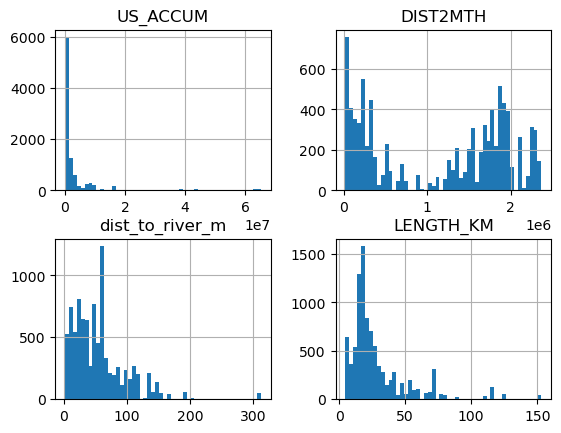

In [57]:
# Check the distribution of the numeric features to see if we need to do any transformation.
river_training[["US_ACCUM","DIST2MTH","dist_to_river_m","LENGTH_KM"]].hist(bins=50)


### Cleaning Function for final columns
**Preprocessing plan (NAME excluded from modeling):**
1) Parse Sample Date to datetime and derive time features (year/month/dayofyear).
2) Clean and one-hot encode categorical river attributes: CLASS, LINK_TYPE, PRIMARY, END.
3) Convert flags/orders to numeric: MAINCHAN (0/1 int), STRAHLER/SHREVE (integer-like).
4) Keep numeric features as-is (no scaling for tree models), and add log1p transforms for heavy-tailed variables: `log1p(US_ACCUM)`, `log1p(DIST2MTH)` (optionally log1p(dist_to_river_m)).


In [93]:
import numpy as np
import pandas as pd

def river_features_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleaning for prediction features (targets may be missing):
      - Sample Date -> datetime
      - MAINCHAN/STRAHLER/SHREVE -> Int64
      - log1p_US_ACCUM
      - One-hot encode: CLASS, LINK_TYPE, END
      - Do NOT drop rows based on target columns (they may be empty)
    """
    out = df.copy()

    # Drop rows missing essential feature fields (adjust if you prefer imputation instead)
    need = ["CLASS", "LINK_TYPE", "END", "US_ACCUM", "Sample Date", "Latitude", "Longitude"]
    need = [c for c in need if c in out.columns]
    out = out.dropna(subset=need)

    # Date parsing
    out["Sample Date"] = pd.to_datetime(out["Sample Date"], errors="coerce", dayfirst=True)
    out = out.dropna(subset=["Sample Date"])

    # Integer-like fields
    for col in ["MAINCHAN", "STRAHLER", "SHREVE"]:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors="coerce").round(0).astype("Int64")

    # log1p US_ACCUM
    x = pd.to_numeric(out["US_ACCUM"], errors="coerce")
    out["log1p_US_ACCUM"] = np.log1p(x.clip(lower=0))

    # One-hot encode categoricals (no dummy_na since we dropped missing)
    cat_cols = [c for c in ["CLASS", "LINK_TYPE", "END"] if c in out.columns]
    out = pd.get_dummies(out, columns=cat_cols, dummy_na=False)

    return out


In [94]:
water_river_train_transformed = river_features_cleaning(river_training[final_cols])
water_river_train_transformed.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,NAME,MAINCHAN,LENGTH_KM,dist_to_river_m,...,log1p_US_ACCUM,CLASS_NonPerennial,CLASS_Perennial,CLASS_Unknown,LINK_TYPE_E,LINK_TYPE_I,LINK_TYPE_O,END_M,END_N,END_S
0,-28.760833,17.730278,2011-01-02,128.912,555.0,10.0,Orange,1,17.900700,59.299455,...,17.994993,False,True,False,False,True,False,False,True,False
1,-26.861111,28.884722,2011-01-03,74.720,162.9,163.0,Waterval,0,11.399800,33.055375,...,13.478767,False,True,False,False,True,False,False,True,False
2,-26.450000,28.085833,2011-01-03,89.254,573.0,80.0,Klip,0,14.567000,134.786210,...,12.318293,False,True,False,False,True,False,False,True,False
3,-27.671111,27.236944,2011-01-03,82.000,203.6,101.0,Vals,0,17.004299,49.099896,...,13.099280,False,True,False,False,True,False,False,True,False
4,-27.356667,27.286389,2011-01-03,56.100,145.1,151.0,Heuningspruit,0,34.964600,59.473162,...,11.946216,True,False,False,False,True,False,False,True,False


In [95]:
water_river_validation_transformed = river_features_cleaning(river_validation[final_cols])
water_river_validation_transformed = water_river_validation_transformed.reindex(columns=water_river_train_transformed.columns, fill_value=0)
water_river_validation_transformed.head()


,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,NAME,MAINCHAN,LENGTH_KM,dist_to_river_m,...,log1p_US_ACCUM,CLASS_NonPerennial,CLASS_Perennial,CLASS_Unknown,LINK_TYPE_E,LINK_TYPE_I,LINK_TYPE_O,END_M,END_N,END_S
0,-32.043333,27.822778,2014-09-01,NaN,NaN,NaN,Tsomo,0,13.073500,39.657334,...,13.285776,0,True,False,False,True,False,False,True,0
1,-33.329167,26.077500,2015-09-16,NaN,NaN,NaN,Boesmans,1,5.065830,27.211129,...,12.885262,0,True,False,False,True,False,False,True,0
2,-32.991639,27.640028,2015-05-07,NaN,NaN,NaN,Buffalo,1,65.494904,56.128885,...,12.672187,0,True,False,False,False,True,True,False,0
3,-34.096389,24.439167,2012-02-07,NaN,NaN,NaN,Tsitsikamma,1,32.539398,21.929795,...,10.390239,0,True,False,True,False,False,True,False,0
4,-32.000556,28.581667,2014-10-01,NaN,NaN,NaN,Mbhashe,1,93.651298,89.455905,...,14.024239,0,True,False,False,True,False,False,True,0


In [96]:
water_river_train_transformed.to_csv("water_river_train_transformed.csv", index=False)
water_river_validation_transformed.to_csv("water_river_validation_transformed.csv", index=False)